In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# === FILE SETUP ===
file_map = {
    "2016": "d16_v4.csv",
    "2017": "d17_v4.csv",
    "2018": "d18_v4.csv",
    "2019": "d19_v4.csv",
    "2020": "d20_v4.csv",
    "2021": "d21_v4.csv",
    "2022": "d22_v4.csv",
    "2023": "d23_v4.csv"
}

# === SUBSTANCES ===
top_substances = [
    "Indeno(1,2,3-cd)pyrene",
    "Benzo(a)pyrene",
    "Cypermethrin",
    "Fluoranthene",
    "Copper"
]

# === LOAD & COMBINE DATA ===
dfs = []
for year, file in file_map.items():
    df = pd.read_csv(file)
    df["YEAR"] = int(year)
    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True)

# Clean columns
full_df.columns = full_df.columns.str.strip()
full_df["SUBSTANCE NAME"] = full_df["SUBSTANCE NAME"].astype(str).str.strip()
full_df["REGION"] = full_df["REGION"].astype(str).str.strip()
full_df["QUANTITY RELEASED (kg)"] = pd.to_numeric(full_df["QUANTITY RELEASED (kg)"], errors='coerce')

########################################################################################################
# Define PNEC values in µg/L
pnec_dict = {
    "indeno(1,2,3-cd)pyrene": 0.00017,
    "benzo(a)pyrene": 0.00017,
    "cypermethrin": 3e-05,
    "fluoranthene": 0.000762,
    "copper": 1.0
}

# Standardize substance names in full_df
full_df["SUBSTANCE NAME"] = full_df["SUBSTANCE NAME"].astype(str).str.strip().str.lower()

# Convert quantity released to litres of water needed to dilute to PNEC level
def compute_toxicity_proxy(row):
    substance = row["SUBSTANCE NAME"]
    quantity_kg = row["QUANTITY RELEASED (kg)"]
    pnec = pnec_dict.get(substance)
    if pd.notna(quantity_kg) and substance in pnec_dict:
        return (quantity_kg * 1e9) / pnec  # kg to µg, then divide by PNEC
    return None

full_df["TOXIC LITRES REQUIRED"] = full_df.apply(compute_toxicity_proxy, axis=1)
##########################################################################################

# # === PLOT EACH SUBSTANCE ===
# for substance in top_substances:
#     # Filter substance
#     df_sub = full_df[full_df["SUBSTANCE NAME"].str.lower() == substance.lower()]

#     # Group by COUNTY and YEAR
#     grouped = df_sub.groupby(["REGION", "YEAR"])["TOXIC LITRES REQUIRED"].sum().reset_index()

#     # Get top 5 counties by total emissions
#     top_counties = grouped.groupby("REGION")["TOXIC LITRES REQUIRED"].sum().nlargest(5).index
#     filtered = grouped[grouped["REGION"].isin(top_counties)]

#     # Plot
#     plt.figure(figsize=(10, 6))
#     for county in top_counties:
#         data = filtered[filtered["REGION"] == county]
#         plt.plot(data["YEAR"], data["TOXIC LITRES REQUIRED"], marker='o', label=county)

#     plt.title(f"{substance} Emissions Over Time by County (Top 5)")
#     plt.xlabel("Year")
#     plt.ylabel("Litres Required to Dilute Substance")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


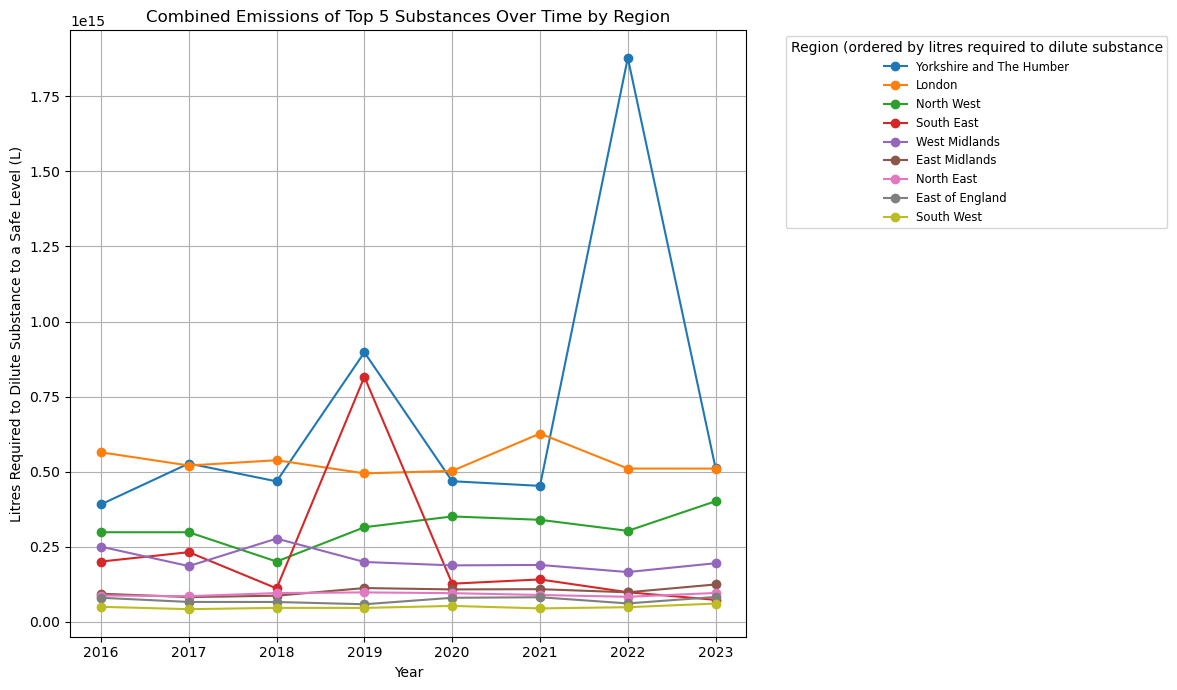

In [4]:
# === Group and clean as before ===
filtered_df = full_df[full_df["SUBSTANCE NAME"].str.lower().isin([s.lower() for s in top_substances])]

filtered_df = filtered_df[
    filtered_df["REGION"].notna() &
    (filtered_df["REGION"].str.lower() != "none") &
    (filtered_df["REGION"].str.lower() != "nan") &
    (filtered_df["REGION"].str.strip() != "")
]

filtered_df = filtered_df[filtered_df["TOXIC LITRES REQUIRED"].notna()]

# === Group by REGION and YEAR ===
region_trends = (
    filtered_df
    .groupby(["REGION", "YEAR"])["TOXIC LITRES REQUIRED"]
    .sum()
    .reset_index()
)

# === Compute total emissions by region for sorting ===
total_by_region = region_trends.groupby("REGION")["TOXIC LITRES REQUIRED"].sum()
sorted_regions = total_by_region.sort_values(ascending=False).index.tolist()

# === Plot with sorted legend ===
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

for region in sorted_regions:
    data = region_trends[region_trends["REGION"] == region]
    plt.plot(data["YEAR"], data["TOXIC LITRES REQUIRED"], marker='o', label=region)

plt.title("Combined Emissions of Top 5 Substances Over Time by Region")
plt.xlabel("Year")
plt.ylabel("Litres Required to Dilute Substance to a Safe Level (L)")
plt.legend(title="Region (ordered by litres required to dilute substance", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
from scipy.stats import f_oneway

# Use already filtered data for top 5 substances
filtered_df = full_df[full_df["SUBSTANCE NAME"].str.lower().isin([s.lower() for s in top_substances])]

# Clean REGION and drop NaNs
filtered_df = filtered_df[
    filtered_df["REGION"].notna() &
    (filtered_df["REGION"].str.lower() != "none") &
    (filtered_df["REGION"].str.lower() != "nan") &
    (filtered_df["REGION"].str.strip() != "")
]

# Keep only numeric emission values
filtered_df = filtered_df[filtered_df["TOXIC LITRES REQUIRED"].notna()]

# Group emissions by region into lists
region_groups = [
    group["TOXIC LITRES REQUIRED"].values
    for _, group in filtered_df.groupby("REGION")
    if len(group) > 1  # F-test needs at least 2 values per group
]

# Run the F-test (ANOVA)
f_stat, p_value = f_oneway(*region_groups)

print("F-statistic:", f_stat)
print("p-value:", p_value)

#If p < 0.05: reject H₀ →→ There's significant variation in pollution levels between all regions

F-statistic: 17.089579975231782
p-value: 1.7786673355343716e-25


In [6]:
from scipy.stats import f_oneway

# Store results per year
f_test_results = []

# Loop through each year
for year in sorted(full_df["YEAR"].unique()):
    df_year = full_df[
        (full_df["YEAR"] == year) &
        (full_df["SUBSTANCE NAME"].str.lower().isin([s.lower() for s in top_substances])) &
        (full_df["REGION"].notna()) &
        (full_df["REGION"].str.lower() != "none") &
        (full_df["REGION"].str.lower() != "nan") &
        (full_df["REGION"].str.strip() != "") &
        (full_df["QUANTITY RELEASED (kg)"].notna())
    ]

    # Group by region
    region_groups = [
        group["TOXIC LITRES REQUIRED"].values
        for _, group in df_year.groupby("REGION")
        if len(group) > 1
    ]

    # Perform F-test if valid
    if len(region_groups) >= 2:
        f_stat, p_val = f_oneway(*region_groups)
        f_test_results.append({"Year": year, "F-statistic": f_stat, "p-value": p_val})
    else:
        f_test_results.append({"Year": year, "F-statistic": None, "p-value": None})

import pandas as pd

f_results_df = pd.DataFrame(f_test_results)
print(f_results_df)
#If p < 0.05: reject H₀ →→ There's significant variation in pollution levels between regions

   Year  F-statistic       p-value
0  2016     7.412212  1.129377e-09
1  2017     4.378775  3.155615e-05
2  2018     6.345569  4.397936e-08
3  2019     1.562904  1.314494e-01
4  2020     4.957693  4.695667e-06
5  2021     8.406687  3.644800e-11
6  2022     1.610201  1.172919e-01
7  2023     4.712187  1.066186e-05


In [7]:
from scipy.stats import ttest_ind
import pandas as pd


filtered_df["REGION"] = filtered_df["REGION"].str.strip()
filtered_df["YEAR"] = filtered_df["YEAR"].astype(int)

# Sort years
years = sorted(filtered_df["YEAR"].unique())
regions = filtered_df["REGION"].unique()

# Store results
ttest_results = []

for i in range(len(years) - 1):
    y1, y2 = years[i], years[i + 1]

    for region in regions:
        group1 = filtered_df[
            (filtered_df["YEAR"] == y1) & (filtered_df["REGION"] == region)
        ]["TOXIC LITRES REQUIRED"]

        group2 = filtered_df[
            (filtered_df["YEAR"] == y2) & (filtered_df["REGION"] == region)
        ]["TOXIC LITRES REQUIRED"]

        if len(group1) > 1 and len(group2) > 1:
            t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
            ttest_results.append({
                "Region": region,
                "Year 1": y1,
                "Year 2": y2,
                "t-stat": t_stat,
                "p-value": p_val,
                "n1": len(group1),
                "n2": len(group2)
            })

# Convert to DataFrame and view
ttest_df = pd.DataFrame(ttest_results).sort_values(["Region", "Year 1"])
print(ttest_df)  # show sample
#If p < 0.05: reject H₀ →→ There's significant variation in pollution levels between years

                      Region  Year 1  Year 2    t-stat   p-value   n1   n2
0              East Midlands    2016    2017  0.196476  0.844434  105  102
9              East Midlands    2017    2018 -0.033816  0.973057  102  106
18             East Midlands    2018    2019 -0.331292  0.740738  106  117
27             East Midlands    2019    2020 -0.252593  0.800834  117  100
36             East Midlands    2020    2021 -0.016518  0.986838  100  100
..                       ...     ...     ...       ...       ...  ...  ...
26  Yorkshire and The Humber    2018    2019 -0.547535  0.584533  141  163
35  Yorkshire and The Humber    2019    2020  0.714400  0.475714  163  174
44  Yorkshire and The Humber    2020    2021  0.005214  0.995843  174  169
53  Yorkshire and The Humber    2021    2022 -1.095009  0.274788  169  187
62  Yorkshire and The Humber    2022    2023  1.045440  0.297016  187  172

[63 rows x 7 columns]


In [8]:
print("\nT-tests between 2016 and 2023 total TOXIC LITRES REQUIRED by region:")

# Ensure YEAR column is numeric
filtered_df["YEAR"] = pd.to_numeric(filtered_df["YEAR"], errors="coerce")

# Keep only 2016 and 2023 data with valid values
df_years = filtered_df[
    (filtered_df["YEAR"].isin([2016, 2023])) &
    (filtered_df["REGION"].notna()) &
    (filtered_df["TOXIC LITRES REQUIRED"].notna()) &
    (filtered_df["QUANTITY RELEASED (kg)"] != 0)
].copy()

# Standardize region names
df_years["REGION"] = df_years["REGION"].str.strip().str.title()

# Loop through each region and run t-test
for region in df_years["REGION"].unique():
    region_df = df_years[df_years["REGION"] == region]

    vals_2016 = region_df[region_df["YEAR"] == 2016]["TOXIC LITRES REQUIRED"]
    vals_2023 = region_df[region_df["YEAR"] == 2023]["TOXIC LITRES REQUIRED"]

    if len(vals_2016) > 1 and len(vals_2023) > 1:
        t_stat, p_val = ttest_ind(vals_2016, vals_2023, equal_var=False)
        print(f"{region}: t = {t_stat:.4f}, p = {p_val:.4g}")
    else:
        print(f"{region}: Not enough data to run t-test.")



T-tests between 2016 and 2023 total TOXIC LITRES REQUIRED by region:
East Midlands: t = -0.6761, p = 0.5023
East Of England: t = 0.1752, p = 0.8614
London: t = -0.2157, p = 0.83
North East: t = -0.3149, p = 0.7546
North West: t = -0.7663, p = 0.4446
South East: t = 0.7648, p = 0.4464
South West: t = -0.0689, p = 0.9453
West Midlands: t = 0.2228, p = 0.8243
Yorkshire And The Humber: t = -0.4067, p = 0.6856


In [9]:
lowest_pval_row = ttest_df.loc[ttest_df['p-value'].idxmin()]
print("🔍 Lowest p-value result:\n")
print(lowest_pval_row)
#no p-values < 0.05 so no significant change in pollution in any one region in 8 years

🔍 Lowest p-value result:

Region     North West
Year 1           2018
Year 2           2019
t-stat      -1.312588
p-value      0.189946
n1                251
n2                258
Name: 22, dtype: object


In [10]:
from itertools import combinations
from scipy.stats import ttest_ind
import pandas as pd

# Clean and redefine filtered_df
filtered_df = full_df.copy()

# Standardize and clean relevant columns
filtered_df["SUBSTANCE NAME"] = filtered_df["SUBSTANCE NAME"].astype(str).str.strip()
filtered_df["REGION"] = filtered_df["REGION"].astype(str).str.strip()
filtered_df["TOXIC LITRES REQUIRED"] = pd.to_numeric(filtered_df["TOXIC LITRES REQUIRED"], errors="coerce")

# Filter for top substances and valid REGION entries
filtered_df = filtered_df[
    filtered_df["SUBSTANCE NAME"].str.lower().isin([s.lower() for s in top_substances]) &
    filtered_df["REGION"].notna() &
    (filtered_df["REGION"].str.lower() != "none") &
    (filtered_df["REGION"].str.lower() != "nan") &
    (filtered_df["REGION"].str.strip() != "") &
    filtered_df["TOXIC LITRES REQUIRED"].notna()
].copy()

# # Get all region combinations
# region_pairs = list(combinations(filtered_df["REGION"].unique(), 2))

# # Store results
# pairwise_results = []

# for r1, r2 in region_pairs:
#     group1 = filtered_df[filtered_df["REGION"] == r1]["TOXIC LITRES REQUIRED"]
#     group2 = filtered_df[filtered_df["REGION"] == r2]["TOXIC LITRES REQUIRED"]
    
#     # Run t-test only if both groups have >1 value
#     if len(group1) > 1 and len(group2) > 1:
#         t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
#         pairwise_results.append({
#             "Region 1": r1,
#             "Region 2": r2,
#             "t-stat": t_stat,
#             "p-value": p_val,
#             "n1": len(group1),
#             "n2": len(group2)
#         })

# # Display as DataFrame
# pairwise_df = pd.DataFrame(pairwise_results).sort_values("p-value")
# print(pairwise_df)  # Show 10 most significant region pairs


In [11]:
# Ordered list from the legend image (top to bottom)
ordered_regions = [
    "Yorkshire and The Humber",
    "London",
    "North West",
    "South East",
    "West Midlands",
    "East Midlands",
    "North East",
    "East of England",
    "South West"
]

# Store adjacent pairwise results
ordered_pairwise_results = []

for i in range(len(ordered_regions) - 1):
    r1, r2 = ordered_regions[i], ordered_regions[i + 1]
    group1 = filtered_df[filtered_df["REGION"] == r1]["TOXIC LITRES REQUIRED"]
    group2 = filtered_df[filtered_df["REGION"] == r2]["TOXIC LITRES REQUIRED"]
    
    if len(group1) > 1 and len(group2) > 1:
        t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
        ordered_pairwise_results.append({
            "Region 1": r1,
            "Region 2": r2,
            "t-stat": t_stat,
            "p-value": p_val,
            "n1": len(group1),
            "n2": len(group2)
        })

# Create DataFrame
ordered_pairwise_df = pd.DataFrame(ordered_pairwise_results)
print(ordered_pairwise_df)
##If p < 0.05: reject H₀ →→ There's significant variation in pollution levels between the 2 regions

                   Region 1         Region 2    t-stat       p-value    n1  \
0  Yorkshire and The Humber           London -3.634389  2.904254e-04  1301   
1                    London       North West  7.542105  2.939075e-13   411   
2                North West       South East -0.264178  7.916816e-01  1976   
3                South East    West Midlands -0.030692  9.755187e-01  1285   
4             West Midlands    East Midlands  1.910938  5.617070e-02  1165   
5             East Midlands       North East -0.592725  5.534793e-01   831   
6                North East  East of England  2.971491  3.048976e-03   660   
7           East of England       South West  0.920824  3.572781e-01  1058   

     n2  
0   411  
1  1976  
2  1285  
3  1165  
4   831  
5   660  
6  1058  
7   882  


In [12]:
# ---- Additional: Compare North, Midlands, and South groups ----

# Define custom region groupings
midlands = ["East Midlands", "West Midlands"]
north = ["North East", "North West", "Yorkshire and The Humber"]
south = ["East of England", "London", "South East", "South West"]

# Filter and drop NaNs + zero releases
group_df = filtered_df[
    filtered_df["REGION"].notna() &
    (filtered_df["REGION"].str.lower() != "nan") &
    filtered_df["TOXIC LITRES REQUIRED"].notna() &
    (filtered_df["QUANTITY RELEASED (kg)"] != 0)
]

# Extract values
midlands_vals = group_df[group_df["REGION"].isin(midlands)]["TOXIC LITRES REQUIRED"].dropna()
north_vals = group_df[group_df["REGION"].isin(north)]["TOXIC LITRES REQUIRED"].dropna()
south_vals = group_df[group_df["REGION"].isin(south)]["TOXIC LITRES REQUIRED"].dropna()

# Function for clean reporting
def run_ttest(group1, group2, name1, name2):
    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
    print(f"\n{name1} vs. {name2}")
    print(f"t-stat:  {t_stat:.4f}")
    print(f"p-value: {p_val:.4g}")
    print(f"mean({name1}): {group1.mean():.2e} | n = {len(group1)}")
    print(f"mean({name2}): {group2.mean():.2e} | n = {len(group2)}")

# Run comparisons
run_ttest(midlands_vals, north_vals, "Midlands", "North")
run_ttest(midlands_vals, south_vals, "Midlands", "South")
run_ttest(north_vals, south_vals, "North", "South")

# --- Additional: High-population Southern Regions vs. the Rest ---

# Define the two groups
group_a = ["London", "South East", "South West", "East of England"]
group_b = [r for r in filtered_df["REGION"].dropna().unique() if r not in group_a]

# Filter clean dataset again
compare_df = filtered_df[
    filtered_df["REGION"].notna() &
    filtered_df["TOXIC LITRES REQUIRED"].notna() &
    (filtered_df["QUANTITY RELEASED (kg)"] != 0)
]

# Extract values
group_a_vals = compare_df[compare_df["REGION"].isin(group_a)]["TOXIC LITRES REQUIRED"].dropna()
group_b_vals = compare_df[compare_df["REGION"].isin(group_b)]["TOXIC LITRES REQUIRED"].dropna()

# Run and report t-test
t_stat, p_val = ttest_ind(group_a_vals, group_b_vals, equal_var=False)

print("\nHigh-Population Southern Regions vs. Rest")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_val:.4g}")
print(f"mean(Group A - South): {group_a_vals.mean():.2e} | n = {len(group_a_vals)}")
print(f"mean(Group B - Rest):  {group_b_vals.mean():.2e} | n = {len(group_b_vals)}")



Midlands vs. North
t-stat:  -2.0368
p-value: 0.04186
mean(Midlands): 4.81e+12 | n = 511
mean(North): 7.63e+12 | n = 1156

Midlands vs. South
t-stat:  -1.2731
p-value: 0.2032
mean(Midlands): 4.81e+12 | n = 511
mean(South): 5.83e+12 | n = 1203

North vs. South
t-stat:  1.2214
p-value: 0.2221
mean(North): 7.63e+12 | n = 1156
mean(South): 5.83e+12 | n = 1203

High-Population Southern Regions vs. Rest
t-statistic: -0.8187
p-value: 0.413
mean(Group A - South): 5.83e+12 | n = 1203
mean(Group B - Rest):  6.77e+12 | n = 1667


In [13]:
# Define your region groupings
southern_regions = ["London", "South East", "South West", "East of England"]
midlands_regions = ["West Midlands", "East Midlands"]
northern_regions = ["North East", "North West", "Yorkshire and The Humber"]

# Define total population per group
population_by_group = {
    "South": 30707740,
    "Midlands": 11076952,
    "North": 15905631
}
# Filter cleaned data
df_cleaned = filtered_df[
    filtered_df["REGION"].notna() &
    filtered_df["TOXIC LITRES REQUIRED"].notna() &
    (filtered_df["REGION"].str.lower() != "nan") &
    (filtered_df["QUANTITY RELEASED (kg)"] != 0)
]

# Assign region group labels
def assign_group(region):
    if region in southern_regions:
        return "South"
    elif region in midlands_regions:
        return "Midlands"
    elif region in northern_regions:
        return "North"
    else:
        return None

df_cleaned["GROUP"] = df_cleaned["REGION"].apply(assign_group)
group_totals = df_cleaned.groupby("GROUP")["TOXIC LITRES REQUIRED"].sum()

per_capita_emissions = {}

for group in group_totals.index:
    total_emissions = group_totals[group]
    population = population_by_group[group]
    per_capita = total_emissions / population
    per_capita_emissions[group] = per_capita

print("Total TOXIC LITRES REQUIRED per capita:")
for group, value in per_capita_emissions.items():
    print(f"{group}: {value:.2e} litres/person")


Total TOXIC LITRES REQUIRED per capita:
Midlands: 2.22e+08 litres/person
North: 5.55e+08 litres/person
South: 2.29e+08 litres/person


C:\Users\andre\AppData\Local\Temp\ipykernel_20620\964319731.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["GROUP"] = df_cleaned["REGION"].apply(assign_group)


In [14]:
import pandas as pd

# Load the Excel file and read the "MYE2 - Persons" sheet starting from row 8
pop_df = pd.read_excel("mye23tablesew.xlsx", sheet_name="MYE2 - Persons", skiprows=7)

# Keep only rows where Geography is "Region" (case-insensitive)
region_pop_df = pop_df[pop_df["Geography"].str.upper() == "REGION"].copy()

# Clean the 'All ages' population numbers (remove commas/spaces)
region_pop_df["All ages"] = (
    region_pop_df["All ages"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.replace(" ", "", regex=False)
    .astype(int)
)

# Standardize region name formatting to match filtered_df
region_pop_df["REGION"] = region_pop_df["Name"].str.title().str.strip()


In [15]:
# Merge population with pollution (right join from population to keep all regions)
region_pollution = (
    df_cleaned.groupby("REGION")["TOXIC LITRES REQUIRED"]
    .sum()
    .reset_index()
)

region_pollution["REGION"] = region_pollution["REGION"].str.strip().str.title()
region_pop_df["REGION"] = region_pop_df["REGION"].str.strip().str.title()
# Mapping region names from pollution data to match population data
region_name_fix = {
    "East Of England": "East",  # Match your population file
    # Add more fixes if needed
}

# Apply mapping
region_pollution["REGION"] = region_pollution["REGION"].replace(region_name_fix)

merged = region_pop_df[["REGION", "All ages"]].merge(
    region_pollution, on="REGION", how="left"
)

# Fill NaN emissions with 0
merged["TOXIC LITRES REQUIRED"] = merged["TOXIC LITRES REQUIRED"].fillna(0)
merged["TOXIC LITRES PER PERSON"] = merged["TOXIC LITRES REQUIRED"] / merged["All ages"]
merged_sorted = merged.sort_values("TOXIC LITRES PER PERSON", ascending=False)

print(merged_sorted[["REGION", "TOXIC LITRES REQUIRED", "All ages", "TOXIC LITRES PER PERSON"]])


                     REGION  TOXIC LITRES REQUIRED  All ages  \
2  Yorkshire And The Humber           5.591759e+15   5594125   
6                    London           4.264943e+15   8945309   
1                North West           2.503730e+15   7600126   
4             West Midlands           1.646293e+15   6085687   
0                North East           7.263153e+14   2711380   
7                South East           1.795308e+15   9482507   
3             East Midlands           8.100235e+14   4991265   
5                      East           5.719854e+14   6468665   
8                South West           3.871634e+14   5811259   

   TOXIC LITRES PER PERSON  
2             9.995771e+08  
6             4.767799e+08  
1             3.294327e+08  
4             2.705188e+08  
0             2.678766e+08  
7             1.893284e+08  
3             1.622882e+08  
5             8.842402e+07  
8             6.662298e+07  


In [16]:
region_pollution

,REGION,TOXIC LITRES REQUIRED
0,East Midlands,8.100235e+14
1,East,5.719854e+14
2,London,4.264943e+15
3,North East,7.263153e+14
4,North West,2.503730e+15
5,South East,1.795308e+15
6,South West,3.871634e+14
7,West Midlands,1.646293e+15
8,Yorkshire And The Humber,5.591759e+15


In [17]:
from scipy.stats import f_oneway, ttest_ind

# Step 1: Assign group labels to merged_sorted DataFrame
def assign_group(region):
    if region in southern_regions:
        return "South"
    elif region in midlands_regions:
        return "Midlands"
    elif region in northern_regions:
        return "North"
    else:
        return None

merged_sorted["GROUP"] = merged_sorted["REGION"].apply(assign_group)

# Step 2: Extract per capita values per group
north_vals = merged_sorted[merged_sorted["GROUP"] == "North"]["TOXIC LITRES PER PERSON"]
midlands_vals = merged_sorted[merged_sorted["GROUP"] == "Midlands"]["TOXIC LITRES PER PERSON"]
south_vals = merged_sorted[merged_sorted["GROUP"] == "South"]["TOXIC LITRES PER PERSON"]

# Step 3: Run one-way ANOVA
f_stat, p_val = f_oneway(north_vals, midlands_vals, south_vals)

print("\nANOVA on per capita emissions by region group:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value:     {p_val:.4g}")

# Step 4 (optional): Post-hoc pairwise t-tests if ANOVA is significant
if p_val < 0.05:
    print("\nPost-hoc pairwise t-tests:")
    t1, p1 = ttest_ind(north_vals, south_vals, equal_var=False)
    print(f"North vs South:    t = {t1:.4f}, p = {p1:.4g}")

    t2, p2 = ttest_ind(north_vals, midlands_vals, equal_var=False)
    print(f"North vs Midlands: t = {t2:.4f}, p = {p2:.4g}")

    t3, p3 = ttest_ind(south_vals, midlands_vals, equal_var=False)
    print(f"South vs Midlands: t = {t3:.4f}, p = {p3:.4g}")

#p-value < 0.05 implies there is at least one group (south, midlands, north) that's significantly different


ANOVA on per capita emissions by region group:
F-statistic: 0.1467
P-value:     0.868


In [18]:
from itertools import product
from scipy.stats import ttest_ind
import pandas as pd

# Filter for top 2 regions
top_2_regions = ["Yorkshire and The Humber", "London"]
df_top2 = filtered_df[filtered_df["REGION"].isin(top_2_regions)].copy()

# Get counties for each region
counties_r1 = df_top2[df_top2["REGION"] == top_2_regions[0]]["COUNTY"].unique()
counties_r2 = df_top2[df_top2["REGION"] == top_2_regions[1]]["COUNTY"].unique()

# Generate all county pairs (Yorkshire vs London)
county_pairs = list(product(counties_r1, counties_r2))

# Run t-tests between counties
county_results = []

for c1, c2 in county_pairs:
    g1 = df_top2[df_top2["COUNTY"] == c1]["TOXIC LITRES REQUIRED"]
    g2 = df_top2[df_top2["COUNTY"] == c2]["TOXIC LITRES REQUIRED"]
    
    if len(g1) > 1 and len(g2) > 1:
        t_stat, p_val = ttest_ind(g1, g2, equal_var=False)
        county_results.append({
            "County 1": c1,
            "County 2": c2,
            "t-stat": t_stat,
            "p-value": p_val,
            "n1": len(g1),
            "n2": len(g2)
        })

# Create results DataFrame
county_ttest_df = pd.DataFrame(county_results).sort_values("p-value")
print(county_ttest_df)


                        County 1                County 2    t-stat   p-value  \
184  Kingston upon Hull, City of                  Sutton -5.449035  0.000002   
72                     Doncaster                  Sutton -5.446921  0.000002   
86      East Riding of Yorkshire                  Sutton -5.444483  0.000002   
156      North East Lincolnshire                  Sutton -5.439093  0.000002   
114                    Rotherham                  Sutton -5.434896  0.000002   
..                           ...                     ...       ...       ...   
190  Kingston upon Hull, City of    Richmond upon Thames       NaN       NaN   
191  Kingston upon Hull, City of              Hillingdon       NaN       NaN   
192  Kingston upon Hull, City of                Lewisham       NaN       NaN   
193  Kingston upon Hull, City of    Barking and Dagenham       NaN       NaN   
194  Kingston upon Hull, City of  Hammersmith and Fulham       NaN       NaN   

     n1  n2  
184   8  47  
72   76  47

In [19]:
# Filter only for the two regions
top_2_regions = ["Yorkshire and The Humber", "London"]
df_top2 = filtered_df[filtered_df["REGION"].isin(top_2_regions)].copy()

# Count number of counties per region
county_counts = df_top2.groupby("REGION")["COUNTY"].nunique()
print("Number of counties per region:\n", county_counts, "\n")

# Calculate median litres required per county
county_toxicity = (
    df_top2.groupby(["REGION", "COUNTY"])["TOXIC LITRES REQUIRED"]
    .median()
    .reset_index()
)

# Find highest and lowest per region
results = []

for region in top_2_regions:
    region_data = county_toxicity[county_toxicity["REGION"] == region]
    
    most_toxic = region_data.nsmallest(1, "TOXIC LITRES REQUIRED")
    least_toxic = region_data.nlargest(1, "TOXIC LITRES REQUIRED")
    
    results.append((region, "Most toxic (lowest dilution)", most_toxic.iloc[0]["COUNTY"], most_toxic.iloc[0]["TOXIC LITRES REQUIRED"]))
    results.append((region, "Least toxic (highest dilution)", least_toxic.iloc[0]["COUNTY"], least_toxic.iloc[0]["TOXIC LITRES REQUIRED"]))

# Print results
print("Most and least toxic counties in each region:\n")
for region, label, county, litres in results:
    print(f"{region} - {label}: {county} ({litres:.2f} litres required)")


Number of counties per region:
 REGION
London                      14
Yorkshire and The Humber    15
Name: COUNTY, dtype: int64 

Most and least toxic counties in each region:

Yorkshire and The Humber - Most toxic (lowest dilution): Barnsley (0.00 litres required)
Yorkshire and The Humber - Least toxic (highest dilution): Bradford (180405000000.00 litres required)
London - Most toxic (lowest dilution): Barking and Dagenham (0.00 litres required)
London - Least toxic (highest dilution): Newham (4461942257217.85 litres required)


In [20]:
from scipy.stats import ttest_ind
import pandas as pd

# Step 1: Clean the dataset
df_cleaned = filtered_df.copy()

# Remove rows with missing COUNTY, missing TOXIC LITRES REQUIRED, or zero QUANTITY RELEASED
df_cleaned = df_cleaned[
    df_cleaned["COUNTY"].notna() &
    (df_cleaned["COUNTY"].astype(str).str.strip().str.lower() != "nan") &
    df_cleaned["TOXIC LITRES REQUIRED"].notna() &
    (df_cleaned["QUANTITY RELEASED (kg)"] != 0)
]

# Step 2: Work with top 3 regions
top_3_regions = ["Yorkshire and The Humber", "London", "North West"]
df_top3 = df_cleaned[df_cleaned["REGION"].isin(top_3_regions)].copy()

# Step 3: Get top 2 counties by TOTAL toxicity per region
top_county_results = {}

for region in top_3_regions:
    region_df = df_top3[df_top3["REGION"] == region]
    
    county_totals = (
        region_df.groupby("COUNTY")["TOXIC LITRES REQUIRED"]
        .sum()
        .sort_values(ascending=False)
    )

    top_2 = county_totals.head(2).index.tolist()
    if len(top_2) == 2:
        top_county_results[region] = top_2

# Step 4: Perform t-tests between top 2 counties in each region
t_test_results = []

for region, (c1, c2) in top_county_results.items():
    g1 = df_top3[(df_top3["REGION"] == region) & (df_top3["COUNTY"] == c1)]["TOXIC LITRES REQUIRED"].dropna()
    g2 = df_top3[(df_top3["REGION"] == region) & (df_top3["COUNTY"] == c2)]["TOXIC LITRES REQUIRED"].dropna()
    
    if len(g1) > 1 and len(g2) > 1 and g1.nunique() > 1 and g2.nunique() > 1:
        t_stat, p_val = ttest_ind(g1, g2, equal_var=False)
    else:
        t_stat, p_val = float("nan"), float("nan")
    
    t_test_results.append({
        "Region": region,
        "County 1": c1,
        "n1": len(g1),
        "County 2": c2,
        "n2": len(g2),
        "t-stat": t_stat,
        "p-value": p_val
    })

# Step 5: Show results
t_test_df = pd.DataFrame(t_test_results)
print("T-tests between top 2 counties by TOTAL TOXIC LITRES REQUIRED in each region (excluding zero releases):\n")
print(t_test_df)


T-tests between top 2 counties by TOTAL TOXIC LITRES REQUIRED in each region (excluding zero releases):

                     Region   County 1  n1    County 2   n2    t-stat  \
0  Yorkshire and The Humber  Wakefield  32    Kirklees   67  1.187027   
1                    London     Newham  47      Bexley   35  1.803927   
2                North West   Trafford  34  Lancashire  171  4.446818   

    p-value  
0  0.240454  
1  0.075598  
2  0.000090  


In [21]:
# Check the mean and distribution per record
g1 = df_top3[(df_top3["REGION"] == "North West") & (df_top3["COUNTY"] == "Trafford")]["TOXIC LITRES REQUIRED"]
g2 = df_top3[(df_top3["REGION"] == "North West") & (df_top3["COUNTY"] == "Lancashire")]["TOXIC LITRES REQUIRED"]

print("Trafford - mean:", g1.mean(), "| std:", g1.std(), "| n:", len(g1))
print("Lancashire - mean:", g2.mean(), "| std:", g2.std(), "| n:", len(g2))


Trafford - mean: 16514763130806.746 | std: 17721835605621.617 | n: 34
Lancashire - mean: 2926542050918.9136 | std: 4140361531246.6665 | n: 171


In [22]:
# Filter for London counties only, excluding zero releases and missing values
london_df = filtered_df[
    (filtered_df["REGION"] == "London") &
    (filtered_df["COUNTY"].notna()) &
    (filtered_df["TOXIC LITRES REQUIRED"].notna()) &
    (filtered_df["QUANTITY RELEASED (kg)"] != 0)
]

# Calculate total litres required per county, sorted by most polluted (highest first)
london_totals = (
    london_df.groupby("COUNTY")["TOXIC LITRES REQUIRED"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Rename for clarity
london_totals.columns = ["County", "Total TOXIC LITRES REQUIRED"]
print("Total litres required to dilute emissions in London counties:\n")
print(london_totals)


Total litres required to dilute emissions in London counties:

                 County  Total TOXIC LITRES REQUIRED
0                Newham                 1.859759e+15
1                Bexley                 8.357229e+14
2              Hounslow                 7.947897e+14
3               Enfield                 3.477414e+14
4                Sutton                 1.893244e+14
5              Havering                 1.666707e+14
6  Kingston upon Thames                 5.642897e+13
7               Lambeth                 1.450313e+13
8                Ealing                 2.810000e+09


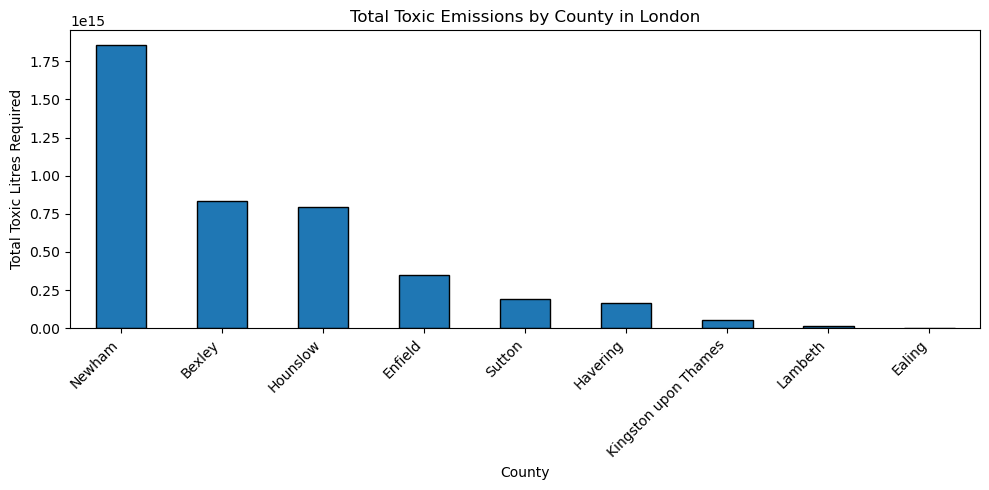

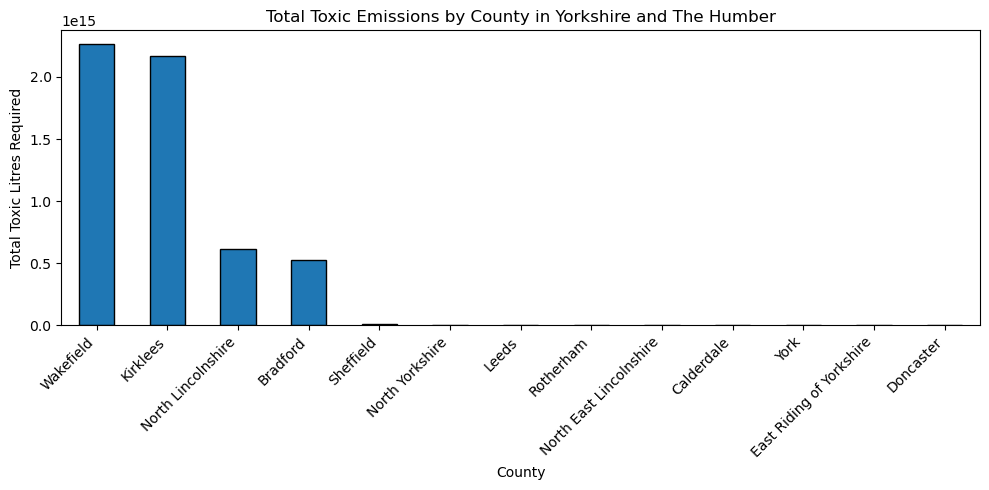

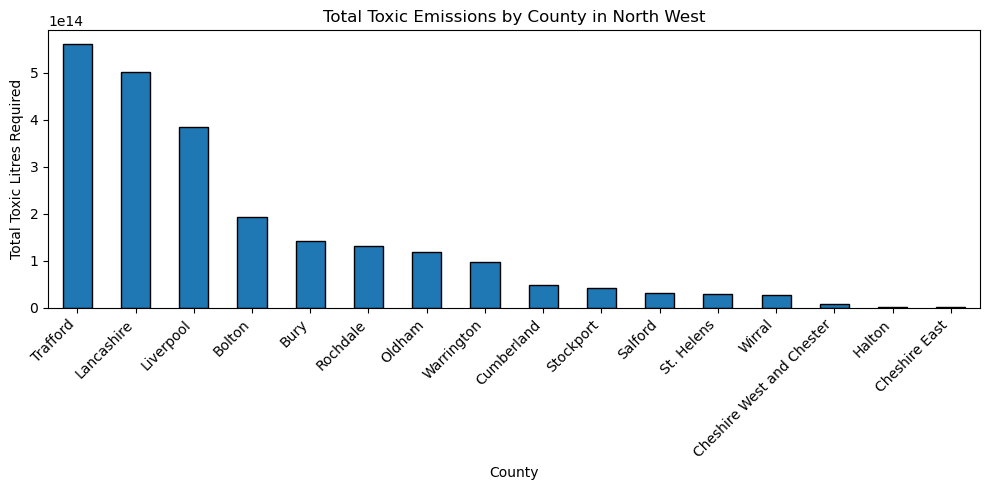

In [30]:
import matplotlib.pyplot as plt

# Define the regions
regions_to_plot = ["London", "Yorkshire and The Humber", "North West"]

for region in regions_to_plot:
    # Aggregate total toxic litres required per county in the region
    county_emissions = (
        df_cleaned[df_cleaned["REGION"] == region]
        .groupby("COUNTY")["TOXIC LITRES REQUIRED"]
        .sum()
        .sort_values(ascending=False)
    )

    # Create individual plot for each region
    plt.figure(figsize=(10, 5))
    county_emissions.plot(kind='bar', edgecolor='black')
    plt.title(f"Total Toxic Emissions by County in {region}")
    plt.ylabel("Total Toxic Litres Required")
    plt.xlabel("County")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


In [31]:
import numpy as np
import pandas as pd

# Gini coefficient function
def gini(array):
    array = np.sort(np.array(array))
    n = len(array)
    if n == 0 or np.sum(array) == 0:
        return np.nan  # avoid divide by zero
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * array) / np.sum(array) - (n + 1)) / n

# Compute Gini for each region
region_gini_list = []

for region in df_cleaned["REGION"].unique():
    region_df = df_cleaned[df_cleaned["REGION"] == region]
    
    # Aggregate by county
    county_totals = region_df.groupby("COUNTY")["TOXIC LITRES REQUIRED"].sum()
    
    if len(county_totals) > 1:
        g = gini(county_totals)
        region_gini_list.append({"Region": region, "Gini Coefficient": g, "N_Counties": len(county_totals)})

# Convert to DataFrame and sort
region_gini_df = pd.DataFrame(region_gini_list).sort_values("Gini Coefficient", ascending=False)
print(region_gini_df)


                     Region  Gini Coefficient  N_Counties
6                South West          0.848849          12
5                South East          0.793499          14
8  Yorkshire and The Humber          0.783474          13
3                North East          0.750253           8
7             West Midlands          0.750072          12
1           East of England          0.691902           9
2                    London          0.602351           9
4                North West          0.593707          16
0             East Midlands          0.446518           6
